In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)



In [20]:
# ==================== ЗАГРУЗКА ДАННЫХ ====================
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/flats.csv")

In [22]:
# Попробуем определить правильный разделитель
file_path = "/content/drive/My Drive/Colab Notebooks/flats.csv"

# Читаем первую строку для проверки
with open(file_path, 'r') as f:
    first_line = f.readline()
    print("Первая строка файла:")
    print(repr(first_line))

# Автоматическое определение разделителя
data = pd.read_csv(file_path, sep=None, engine='python')

print("\nПервые 5 строк данных:")
print(data.head())
print("\n" + "="*80 + "\n")

Первая строка файла:
',price_doc,full_sq,life_sq,num_room,kitch_sq\n'

Первые 5 строк данных:
   Unnamed: 0  price_doc  full_sq  life_sq  num_room  kitch_sq
0        8056    2750000       11     11.0       1.0      12.0
1        8154    7100000       45     27.0       2.0       6.0
2        8287   11700000       77     50.0       3.0       8.0
3        8387   10400000       56     29.0       2.0      10.0
4        8391    6200000       31     21.0       1.0       5.0




In [23]:
# ==================== ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ ====================
print("ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ")
print("="*80)

# Информация о данных
print("\nИнформация о датасете:")
print(data.info())
print("\n" + "-"*80)

# Статистика
print("\nСтатистическое описание:")
print(data.describe())
print("\n" + "-"*80)

# Проверка пропусков
print("\nПропущенные значения:")
print(data.isnull().sum())
print("\n" + "-"*80)

# Удаление ненужного индекса
if 'Unnamed: 0' in data.columns:
    data = data.drop('Unnamed: 0', axis=1)

ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6042 entries, 0 to 6041
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6042 non-null   int64  
 1   price_doc   6042 non-null   int64  
 2   full_sq     6042 non-null   int64  
 3   life_sq     6042 non-null   float64
 4   num_room    6042 non-null   float64
 5   kitch_sq    6042 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 283.3 KB
None

--------------------------------------------------------------------------------

Статистическое описание:
         Unnamed: 0     price_doc      full_sq      life_sq     num_room  \
count   6042.000000  6.042000e+03  6042.000000  6042.000000  6042.000000   
mean   19846.990070  8.750423e+06    53.374545    33.198941     1.997021   
std     6081.011373  6.277290e+06    24.011941    20.190005     0.889523   
min     8056.000000  5.000000e+05     1.000000   


АНАЛИЗ РАСПРЕДЕЛЕНИЙ ПРИЗНАКОВ


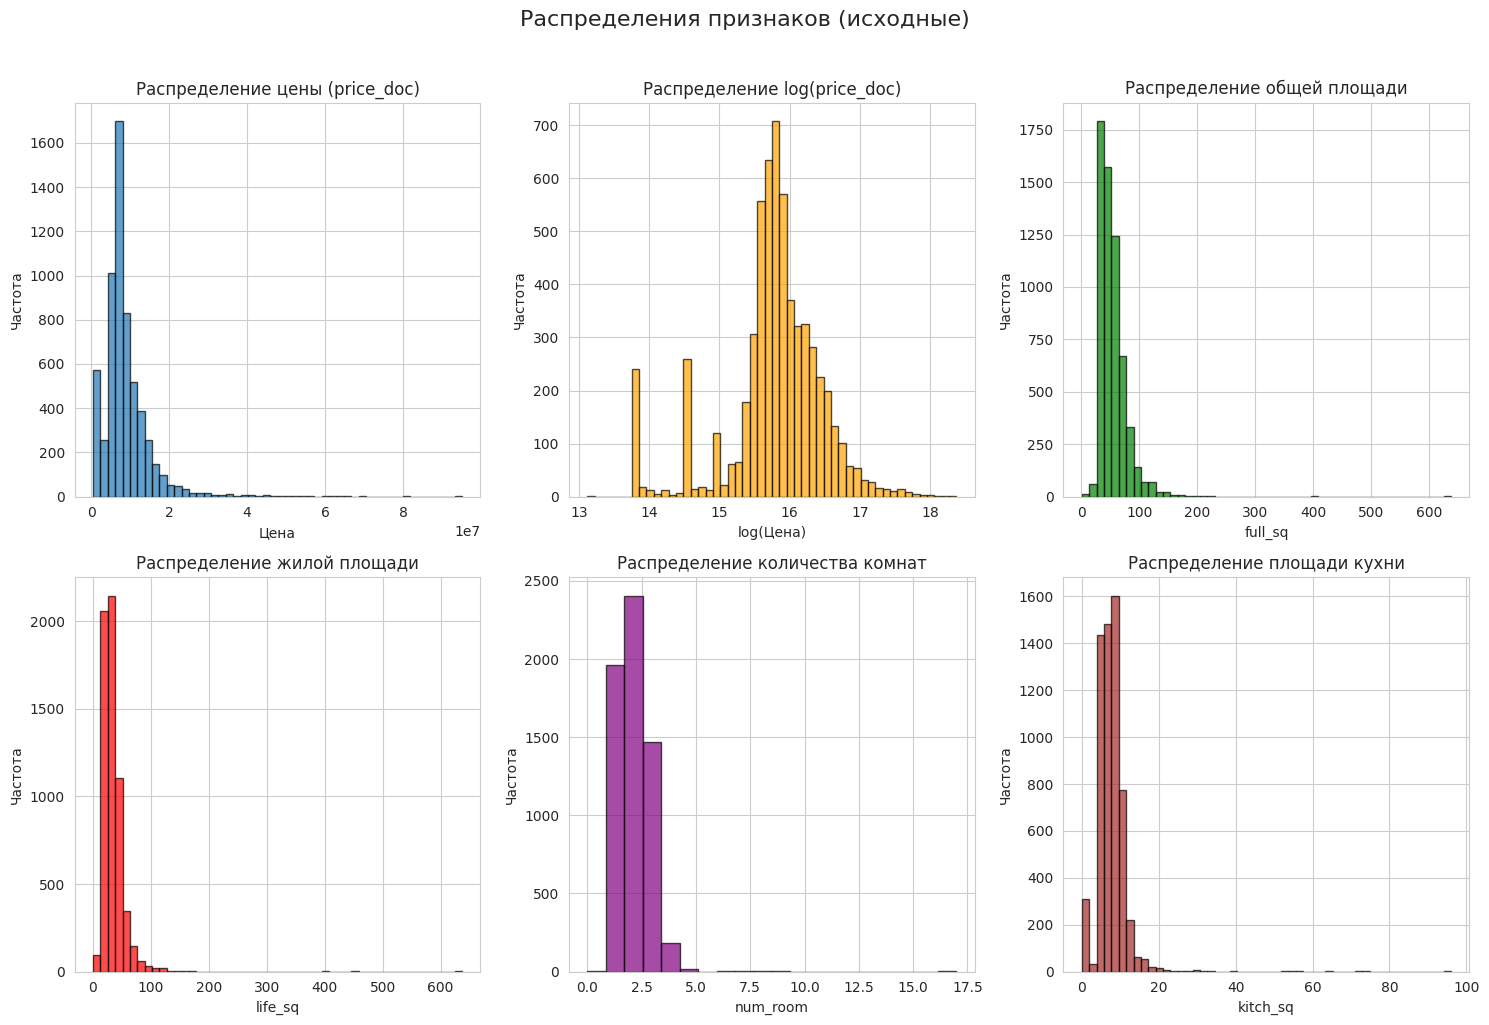


--------------------------------------------------------------------------------
АНАЛИЗ РАСПРЕДЕЛЕНИЙ:
--------------------------------------------------------------------------------

Асимметрия (skewness) исходной цены: 3.565
Асимметрия (skewness) log(цены):     -0.809

Интерпретация:
✓ Распределение цены СИЛЬНО скошено вправо (skew = 3.565)
✓ После логарифмирования асимметрия УМЕНЬШИЛАСЬ на 77.3%
✓ Распределение log(цены) ближе к нормальному!




In [24]:
# ==================== АНАЛИЗ РАСПРЕДЕЛЕНИЙ ====================
print("\nАНАЛИЗ РАСПРЕДЕЛЕНИЙ ПРИЗНАКОВ")
print("="*80)

# Создание графиков распределений
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Распределения признаков (исходные)', fontsize=16, y=1.02)

# Распределение цены
axes[0, 0].hist(data['price_doc'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Распределение цены (price_doc)')
axes[0, 0].set_xlabel('Цена')
axes[0, 0].set_ylabel('Частота')

# Распределение логарифма цены
log_price = np.log(data['price_doc'])
axes[0, 1].hist(log_price, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Распределение log(price_doc)')
axes[0, 1].set_xlabel('log(Цена)')
axes[0, 1].set_ylabel('Частота')

# Распределение общей площади
axes[0, 2].hist(data['full_sq'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 2].set_title('Распределение общей площади')
axes[0, 2].set_xlabel('full_sq')
axes[0, 2].set_ylabel('Частота')

# Распределение жилой площади
axes[1, 0].hist(data['life_sq'], bins=50, edgecolor='black', alpha=0.7, color='red')
axes[1, 0].set_title('Распределение жилой площади')
axes[1, 0].set_xlabel('life_sq')
axes[1, 0].set_ylabel('Частота')

# Распределение количества комнат
axes[1, 1].hist(data['num_room'], bins=20, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_title('Распределение количества комнат')
axes[1, 1].set_xlabel('num_room')
axes[1, 1].set_ylabel('Частота')

# Распределение площади кухни
axes[1, 2].hist(data['kitch_sq'], bins=50, edgecolor='black', alpha=0.7, color='brown')
axes[1, 2].set_title('Распределение площади кухни')
axes[1, 2].set_xlabel('kitch_sq')
axes[1, 2].set_ylabel('Частота')

plt.tight_layout()
plt.show()

# Анализ асимметрии распределений
from scipy import stats

skew_price = stats.skew(data['price_doc'])
skew_log_price = stats.skew(log_price)

print("\n" + "-"*80)
print("АНАЛИЗ РАСПРЕДЕЛЕНИЙ:")
print("-"*80)
print(f"\nАсимметрия (skewness) исходной цены: {skew_price:.3f}")
print(f"Асимметрия (skewness) log(цены):     {skew_log_price:.3f}")

print("\nИнтерпретация:")
if abs(skew_price) > 1:
    print(f"✓ Распределение цены СИЛЬНО скошено вправо (skew = {skew_price:.3f})")
elif abs(skew_price) > 0.5:
    print(f"✓ Распределение цены умеренно скошено (skew = {skew_price:.3f})")
else:
    print(f"✓ Распределение цены близко к симметричному (skew = {skew_price:.3f})")

if abs(skew_log_price) < abs(skew_price):
    improvement = ((abs(skew_price) - abs(skew_log_price)) / abs(skew_price) * 100)
    print(f"✓ После логарифмирования асимметрия УМЕНЬШИЛАСЬ на {improvement:.1f}%")
    print(f"✓ Распределение log(цены) ближе к нормальному!")

print("\n" + "="*80 + "\n")

In [25]:
# ==================== ПОДГОТОВКА ПРИЗНАКОВ ====================
print("ПОДГОТОВКА ПРИЗНАКОВ")
print("="*80)

# Создание логарифма целевой переменной
data['log_price'] = np.log(data['price_doc'])

# Выбираем признаки для модели
features = ['full_sq', 'life_sq', 'num_room', 'kitch_sq']
X = data[features].values
y = data['log_price'].values

print(f"\nИспользуемые признаки: {features}")
print(f"Целевая переменная: log(price_doc)")
print(f"Размер выборки: {len(X)} наблюдений")

# Стандартизация признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nПризнаки стандартизированы (mean=0, std=1)")
print("\n" + "="*80 + "\n")

ПОДГОТОВКА ПРИЗНАКОВ

Используемые признаки: ['full_sq', 'life_sq', 'num_room', 'kitch_sq']
Целевая переменная: log(price_doc)
Размер выборки: 6042 наблюдений

Признаки стандартизированы (mean=0, std=1)




In [26]:
# ==================== БАЙЕСОВСКАЯ ЛИНЕЙНАЯ РЕГРЕССИЯ ====================
print("ПОСТРОЕНИЕ БАЙЕСОВСКОЙ ЛИНЕЙНОЙ РЕГРЕССИИ")
print("="*80)

# Создание модели
with pm.Model() as bayesian_model:
    # Приоры для коэффициентов
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    betas = pm.Normal('betas', mu=0, sigma=10, shape=len(features))

    # Приор для стандартного отклонения
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Линейная модель
    mu = alpha + pm.math.dot(X_scaled, betas)

    # Функция правдоподобия
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y)

    # Сэмплирование
    print("\nЗапуск MCMC сэмплирования...")
    trace = pm.sample(2000, tune=1000, return_inferencedata=True,
                      random_seed=42, progressbar=True)

print("\nСэмплирование завершено!")
print("\n" + "-"*80)

# Вывод summary байесовской модели
print("\nРЕЗУЛЬТАТЫ БАЙЕСОВСКОЙ РЕГРЕССИИ:")
print(pm.summary(trace))
print("\n" + "="*80 + "\n")

ПОСТРОЕНИЕ БАЙЕСОВСКОЙ ЛИНЕЙНОЙ РЕГРЕССИИ

Запуск MCMC сэмплирования...


Output()


Сэмплирование завершено!

--------------------------------------------------------------------------------

РЕЗУЛЬТАТЫ БАЙЕСОВСКОЙ РЕГРЕССИИ:
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha     15.773  0.008  15.760   15.788        0.0      0.0    4330.0   
betas[0]   0.317  0.019   0.281    0.353        0.0      0.0    1705.0   
betas[1]  -0.067  0.016  -0.094   -0.035        0.0      0.0    2277.0   
betas[2]   0.089  0.010   0.069    0.109        0.0      0.0    3277.0   
betas[3]   0.050  0.009   0.033    0.065        0.0      0.0    2873.0   
sigma      0.597  0.005   0.587    0.607        0.0      0.0    4548.0   

          ess_tail  r_hat  
alpha       2614.0    1.0  
betas[0]    2411.0    1.0  
betas[1]    2703.0    1.0  
betas[2]    2785.0    1.0  
betas[3]    2515.0    1.0  
sigma       2802.0    1.0  




In [27]:
# ==================== SKLEARN ЛИНЕЙНАЯ РЕГРЕССИЯ ====================
print("ПОСТРОЕНИЕ КЛАССИЧЕСКОЙ ЛИНЕЙНОЙ РЕГРЕССИИ (sklearn)")
print("="*80)

# Обучение модели
lr_model = LinearRegression()
lr_model.fit(X_scaled, y)

# Вывод коэффициентов
print("\nКОЭФФИЦИЕНТЫ КЛАССИЧЕСКОЙ ЛИНЕЙНОЙ РЕГРЕССИИ:")
print(f"\nIntercept (альфа): {lr_model.intercept_:.4f}")
print("\nКоэффициенты при признаках:")
for i, feature in enumerate(features):
    print(f"  {feature:12s}: {lr_model.coef_[i]:.4f}")

print("\n" + "="*80 + "\n")


ПОСТРОЕНИЕ КЛАССИЧЕСКОЙ ЛИНЕЙНОЙ РЕГРЕССИИ (sklearn)

КОЭФФИЦИЕНТЫ КЛАССИЧЕСКОЙ ЛИНЕЙНОЙ РЕГРЕССИИ:

Intercept (альфа): 15.7735

Коэффициенты при признаках:
  full_sq     : 0.3171
  life_sq     : -0.0666
  num_room    : 0.0897
  kitch_sq    : 0.0497




СРАВНЕНИЕ КОЭФФИЦИЕНТОВ

ТАБЛИЦА СРАВНЕНИЯ КОЭФФИЦИЕНТОВ:
  Признак  Байесовская регрессия  sklearn регрессия   Разница  Разница (%)
Intercept                 15.773          15.773452 -0.000452    -0.002867
  full_sq                  0.317           0.317050 -0.000050    -0.015783
  life_sq                 -0.067          -0.066622 -0.000378    -0.567607
 num_room                  0.089           0.089685 -0.000685    -0.764223
 kitch_sq                  0.050           0.049745  0.000255     0.511813


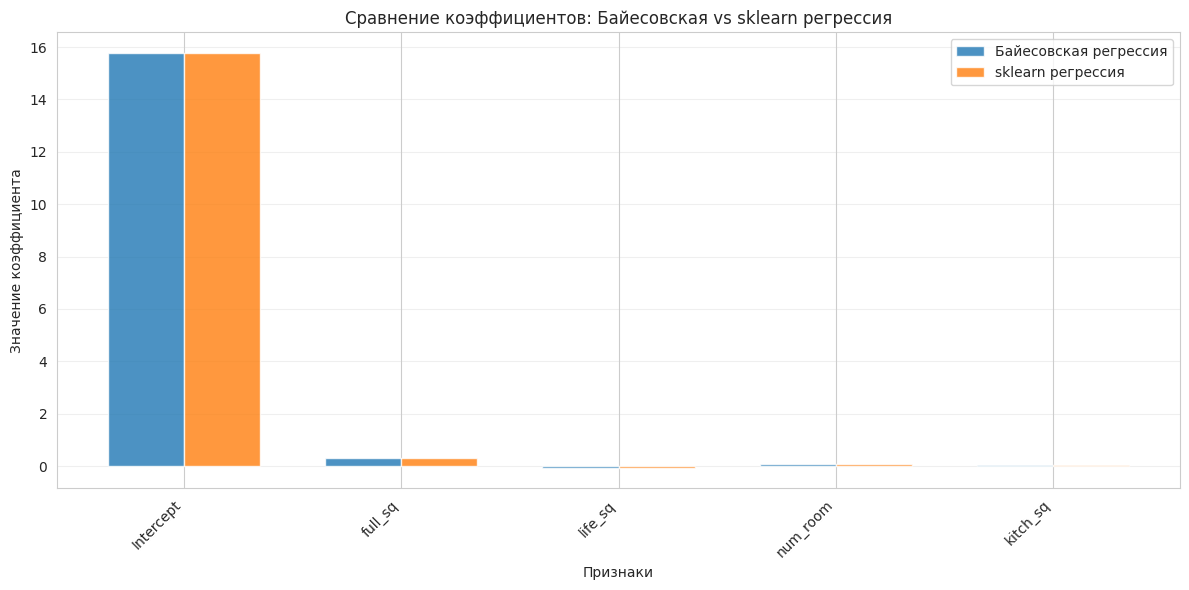



ВЫВОДЫ:

✓ Коэффициенты практически ИДЕНТИЧНЫ (макс. разница < 0.01)

Это ожидаемый результат, так как:
1. Байесовская регрессия с нормальными приорами и достаточным количеством данных
   даёт результаты, близкие к классической линейной регрессии
2. Использованы одни и те же признаки и данные
3. Стандартизация признаков помогает сходимости обеих моделей

ПРОЕКТ ЗАВЕРШЁН!


In [28]:
# ==================== СРАВНЕНИЕ КОЭФФИЦИЕНТОВ ====================
print("СРАВНЕНИЕ КОЭФФИЦИЕНТОВ")
print("="*80)

# Получение средних значений из байесовской модели
bayesian_summary = pm.summary(trace)
bayesian_alpha = bayesian_summary.loc['alpha', 'mean']
bayesian_betas = [bayesian_summary.loc[f'betas[{i}]', 'mean'] for i in range(len(features))]

# Создание таблицы сравнения
comparison_df = pd.DataFrame({
    'Признак': ['Intercept'] + features,
    'Байесовская регрессия': [bayesian_alpha] + bayesian_betas,
    'sklearn регрессия': [lr_model.intercept_] + list(lr_model.coef_)
})

comparison_df['Разница'] = comparison_df['Байесовская регрессия'] - comparison_df['sklearn регрессия']
comparison_df['Разница (%)'] = (comparison_df['Разница'] / comparison_df['sklearn регрессия'].abs() * 100)

print("\nТАБЛИЦА СРАВНЕНИЯ КОЭФФИЦИЕНТОВ:")
print(comparison_df.to_string(index=False))

# Визуализация сравнения
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(comparison_df))
width = 0.35

ax.bar(x_pos - width/2, comparison_df['Байесовская регрессия'],
       width, label='Байесовская регрессия', alpha=0.8)
ax.bar(x_pos + width/2, comparison_df['sklearn регрессия'],
       width, label='sklearn регрессия', alpha=0.8)

ax.set_xlabel('Признаки')
ax.set_ylabel('Значение коэффициента')
ax.set_title('Сравнение коэффициентов: Байесовская vs sklearn регрессия')
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['Признак'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("\nВЫВОДЫ:")
print("="*80)

# Проверка близости коэффициентов
max_diff = comparison_df['Разница'].abs().max()
if max_diff < 0.01:
    print("\n✓ Коэффициенты практически ИДЕНТИЧНЫ (макс. разница < 0.01)")
elif max_diff < 0.1:
    print("\n✓ Коэффициенты ОЧЕНЬ ПОХОЖИ (макс. разница < 0.1)")
else:
    print(f"\n! Коэффициенты ОТЛИЧАЮТСЯ (макс. разница = {max_diff:.4f})")

print("\nЭто ожидаемый результат, так как:")
print("1. Байесовская регрессия с нормальными приорами и достаточным количеством данных")
print("   даёт результаты, близкие к классической линейной регрессии")
print("2. Использованы одни и те же признаки и данные")
print("3. Стандартизация признаков помогает сходимости обеих моделей")

print("\n" + "="*80)
print("ПРОЕКТ ЗАВЕРШЁН!")
print("="*80)
